# Analysis of cortical network model

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from tqdm import tqdm
from network import NeuralNetwork
from logger import logger
from utils import *

t0 = time.perf_counter()

## Input parameters

In [3]:
# Drive parameters
noise_amp = 1e-2  # noise amplitude (mA/cm2)

# Stimulus parameters
start = 50 # start time (ms)
dur = 150  # duration (ms)
Pref = 1e6  # pressure amplitude (Pa)
Pmax = 3e6  # maximum pressure amplitude (Pa)
Iref = pressure_to_intensity(Pref) / 1e4  # corresponding intensity (W/cm2)
Imax = pressure_to_intensity(Pmax) / 1e4  # corresponding intensity (W/cm2)
Isppa_range = sqrtspace(0, Imax, 15)  # range of intensities to sweep
Isppa_range_dense = sqrtspace(0, Imax, 30)  # dense range of intensities to sweep

# Simulation parameters
tstop = 500  # default simulation duration (ms)
nreps = 1  # number of repetitions per simulation (for sweep trends)

# Logging
paramsstr = {
    'noise': [
        f'amplitude = {noise_amp:.3f} mA/cm2'],
    'stimulus': [
        f'start = {start} ms',
        f'duration = {dur} ms',
        f'P = {Pref * 1e-6:.1f} MPa <-> I = {Iref:.2f} W/cm2',
        f'range of intensities = {Isppa_range[0]:.2f} - {Isppa_range[-1]:.2f} W/cm2'],
    'simulation': [
        f'duration = {tstop} ms',
        f'number of repetitions (for sweeps) = {nreps}']
}
paramsstr = {k: '\n'.join([f'       - {x}' for x in v]) for k, v in paramsstr.items()}
paramsstr = '\n'.join([f'   - {k}:\n{v}' for k, v in paramsstr.items()]) 
logger.info('Input parameters:\n' + paramsstr)

 12/12/2023 17:48:22: Input parameters:
   - noise:
       - amplitude = 0.010 mA/cm2
   - stimulus:
       - start = 50 ms
       - duration = 150 ms
       - P = 1.0 MPa <-> I = 30.91 W/cm2
       - range of intensities = 0.00 - 278.22 W/cm2
   - simulation:
       - duration = 500 ms
       - number of repetitions (for sweeps) = 1


## Network model

In [4]:
# Initialize 3-nodes model temperature-dependent components
nnodes = 3
model = NeuralNetwork(
    nnodes, 
    Q10_rates=3,
    Q10_gNa=1.40,
    Q10_gKd=4.75,
    gKT=0.58e-9 / (NeuralNetwork.Acell * NeuralNetwork.UM_TO_CM**2),  # S/cm2
    a=1e-4, 
    b=0.5,
    synweight=90e-6, # synaptic weight (S/cm2)
)

# Set stimulus
model.set_stim(Iref, start=start, dur=dur)

# Set simulation duration
model.tstop = tstop

 12/12/2023 17:48:22: NeuralNetwork(3): created 3 nodes
 12/12/2023 17:48:22: NeuralNetwork(3): connecting all node pairs
 12/12/2023 17:48:22: NeuralNetwork(3): setting Q10_rates = 3 on all nodes
 12/12/2023 17:48:22: NeuralNetwork(3): setting Q10_gNa = 1.4 on all nodes
 12/12/2023 17:48:22: NeuralNetwork(3): setting Q10_gKd = 4.75 on all nodes
 12/12/2023 17:48:22: NeuralNetwork(3): setting gKT = 4.898648648648648e-06 on all nodes
 12/12/2023 17:48:22: NeuralNetwork(3): setting a = 0.0001 on all nodes
 12/12/2023 17:48:22: NeuralNetwork(3): setting b = 0.5 on all nodes
 12/12/2023 17:48:22: NeuralNetwork(3): initialized
 12/12/2023 17:48:22: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 30.9 W/cm2
    - node 1: 30.9 W/cm2
    - node 2: 30.9 W/cm2


## Simulations

### Test simulation

 12/12/2023 17:48:22: NeuralNetwork(3): disabled currents: iNaKPump
 12/12/2023 17:48:22: Noise current injection requires fixed time step -> setting dt = 0.025 ms


 12/12/2023 17:48:22: NeuralNetwork(3): simulating for 500.00 ms
 12/12/2023 17:48:22: NeuralNetwork(3): extracting output results
 12/12/2023 17:48:22: NeuralNetwork(3): max temperature increase:
    - node 0: ΔT = 0.4 °C
    - node 1: ΔT = 0.4 °C
    - node 2: ΔT = 0.4 °C
 12/12/2023 17:48:22: NeuralNetwork(3): number of spikes:
    - node 0: n = 11 spikes
    - node 1: n = 10 spikes
    - node 2: n = 11 spikes
 12/12/2023 17:48:22: NeuralNetwork(3): firing rate:
    - node 0: FR = 110.6 ±24.9  FR
    - node 1: FR = 108.8 ±21.3  FR
    - node 2: FR = 107.7 ±23.9  FR
 12/12/2023 17:48:22: NeuralNetwork(3): plotting results


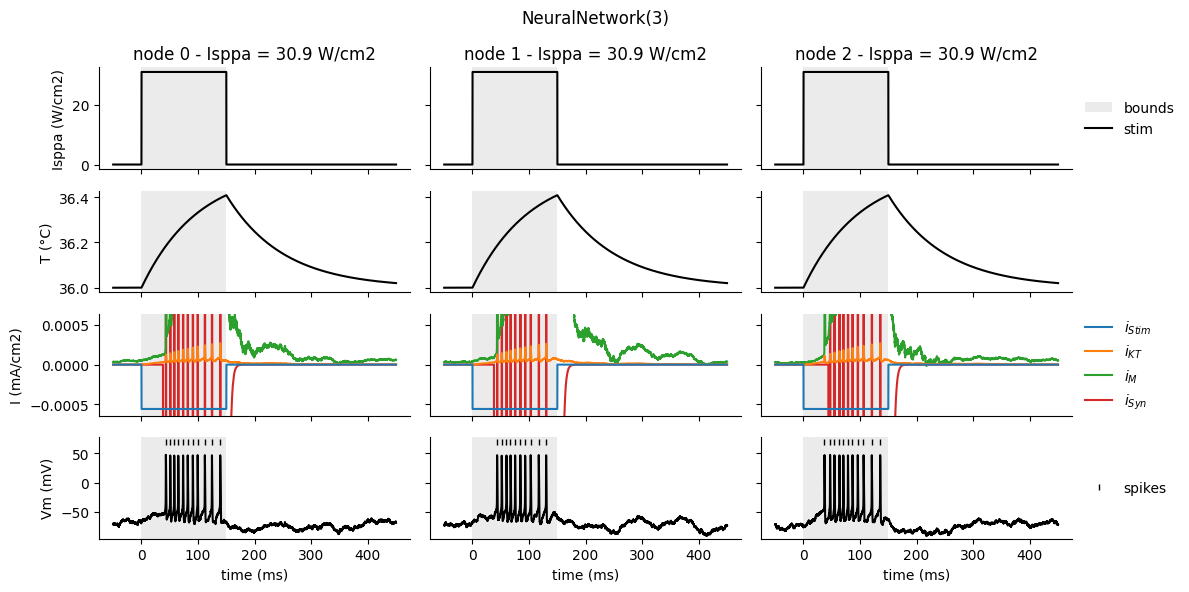

In [5]:
model.noise_amp = noise_amp
data = model.simulate()
fig = model.plot_results(
    data, 
    exclude=['conductances', 'iNa', 'iKd', 'iLeak', 'iNoise'], 
    clip_currents=True)

### Detailed Isppa dependencies and sub-threshold simulations for optimal parameter combinations

 12/12/2023 19:13:04: NeuralNetwork(3): running simulation sweep across 30 stimulus intensities


100%|██████████| 30/30 [05:21<00:00, 10.71s/it]


 12/12/2023 19:19:41: NeuralNetwork(3): running simulation sweep across 30 stimulus intensities


100%|██████████| 30/30 [05:27<00:00, 10.91s/it]


 12/12/2023 19:26:42: NeuralNetwork(3): running simulation sweep across 30 stimulus intensities


100%|██████████| 30/30 [05:15<00:00, 10.53s/it]


 12/12/2023 19:33:10: NeuralNetwork(3): running simulation sweep across 30 stimulus intensities


100%|██████████| 30/30 [05:23<00:00, 10.77s/it]


 12/12/2023 19:40:13: NeuralNetwork(3): running simulation sweep across 30 stimulus intensities


100%|██████████| 30/30 [05:23<00:00, 10.78s/it]


 12/12/2023 19:47:03: NeuralNetwork(3): running simulation sweep across 30 stimulus intensities


100%|██████████| 30/30 [05:32<00:00, 11.09s/it]


 12/12/2023 19:54:20: NeuralNetwork(3): running simulation sweep across 30 stimulus intensities


100%|██████████| 30/30 [05:23<00:00, 10.78s/it]


 12/12/2023 20:00:59: NeuralNetwork(3): running simulation sweep across 30 stimulus intensities


100%|██████████| 30/30 [05:29<00:00, 10.99s/it]


 12/12/2023 20:08:04: NeuralNetwork(3): running simulation sweep across 30 stimulus intensities


100%|██████████| 30/30 [05:15<00:00, 10.53s/it]


 12/12/2023 20:14:34: NeuralNetwork(3): running simulation sweep across 30 stimulus intensities


100%|██████████| 30/30 [05:23<00:00, 10.77s/it]


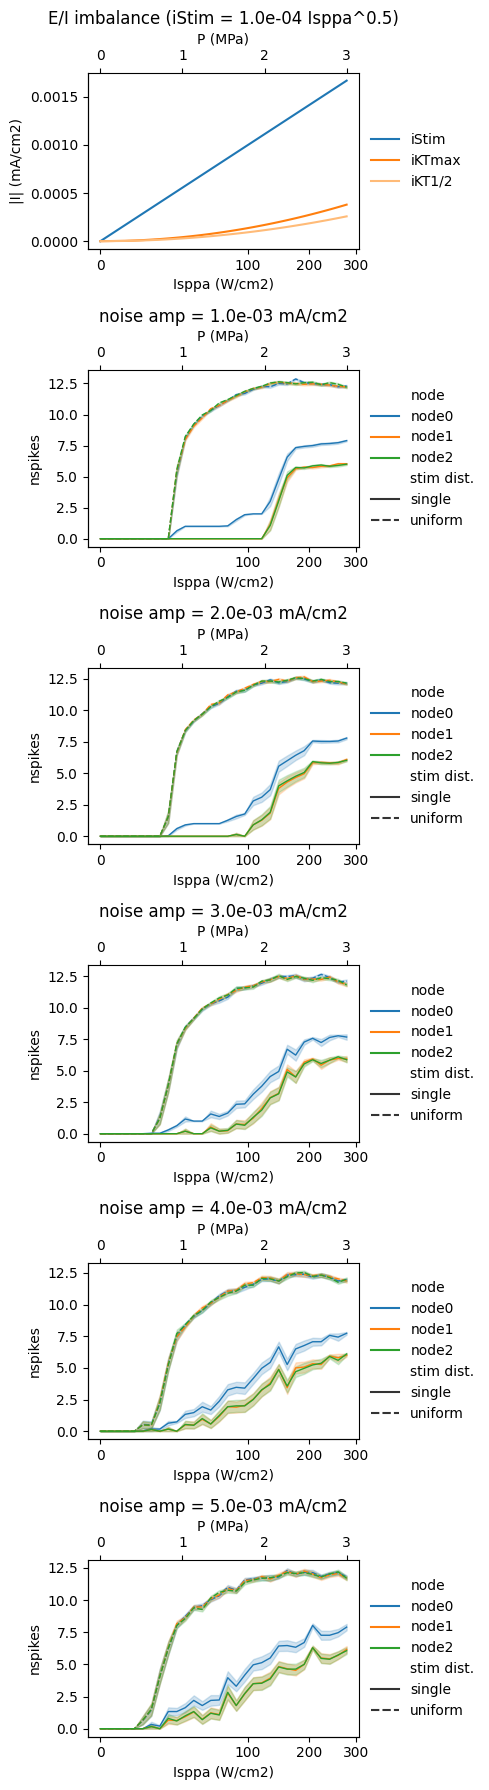

In [20]:
# Define range of noise amplitudes to sweep
noise_range = np.linspace(1, 5, 5) * 1e-3  # mA/cm2

# Initialize metric container
metric = []

# For each noise amplitude
for noise_amp in noise_range:
    # Set noise amplitude
    model.noise_amp = noise_amp

    # Run comparative simulations across Isppa range and extract spike counts
    metric.append(model.run_comparative_sweep(
        Isppa_range_dense, 
        'nspikes',
        nreps=30
    ))

# Concatenate metric dataframes
metric = model.concatenate_outputs(noise_range, metric, 'noise_amp')

# Create figure
fig, axes = plt.subplots(noise_range.size + 1, 1, figsize=(5, 3 * (noise_range.size + 1)))

# Pot E/I imbalance across Isppa range
model.plot_EI_imbalance(Imax, ax=axes[0], legend=True, xscale='sqrt')
axes[0].set_title(f'E/I imbalance (iStim = {model.a:.1e} Isppa^{model.b})', fontsize=12)

# Plot spike count across Isppa range for each noise amplitude
for ax, (noise_amp, gmetric) in zip(axes[1:], metric.groupby('noise_amp')):
    model.plot_sweep_results(
        gmetric.droplevel('noise_amp'), 
        ax=ax, 
        legend=True, 
        marker=None, 
        xscale='sqrt',
        estimator='mean',
    )
    ax.set_title(f'noise amp = {noise_amp:.1e} mA/cm2', fontsize=12)

# Adjust figure layout
fig.tight_layout()

# Save figure
fig.savefig('nspikes_vs_pressure.pdf')

### Comparative detailed simulations for just sub-threshold conditions 

 12/12/2023 21:31:05: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 33.1 W/cm2
    - node 1: 0.0 W/cm2
    - node 2: 0.0 W/cm2
 12/12/2023 21:31:05: NeuralNetwork(3): simulating for 500.00 ms
 12/12/2023 21:31:05: NeuralNetwork(3): simulating for 500.00 ms
 12/12/2023 21:31:06: NeuralNetwork(3): simulating for 500.00 ms
 12/12/2023 21:31:06: NeuralNetwork(3): simulating for 500.00 ms
 12/12/2023 21:31:06: NeuralNetwork(3): simulating for 500.00 ms
 12/12/2023 21:31:07: NeuralNetwork(3): simulating for 500.00 ms
 12/12/2023 21:31:07: NeuralNetwork(3): simulating for 500.00 ms
 12/12/2023 21:31:07: NeuralNetwork(3): simulating for 500.00 ms
 12/12/2023 21:31:08: NeuralNetwork(3): simulating for 500.00 ms
 12/12/2023 21:31:08: NeuralNetwork(3): plotting results
 12/12/2023 21:31:09: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 16.2 W/cm2
    - node 1: 16.2 W/cm2
    - node 2: 16.2 W/cm2
 12/12/2023 21

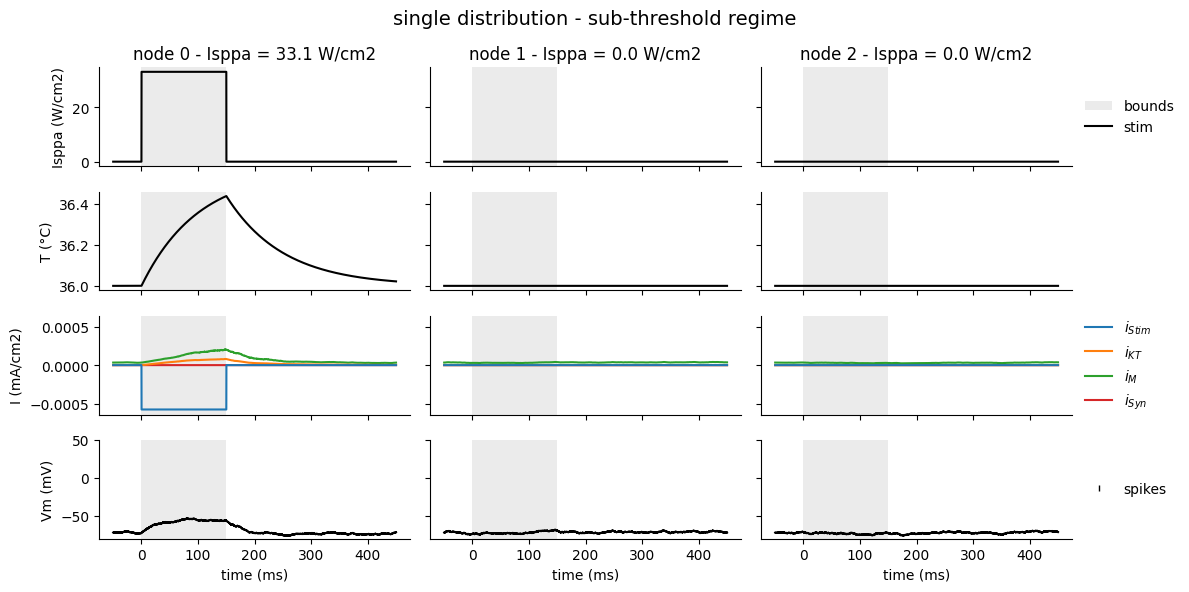

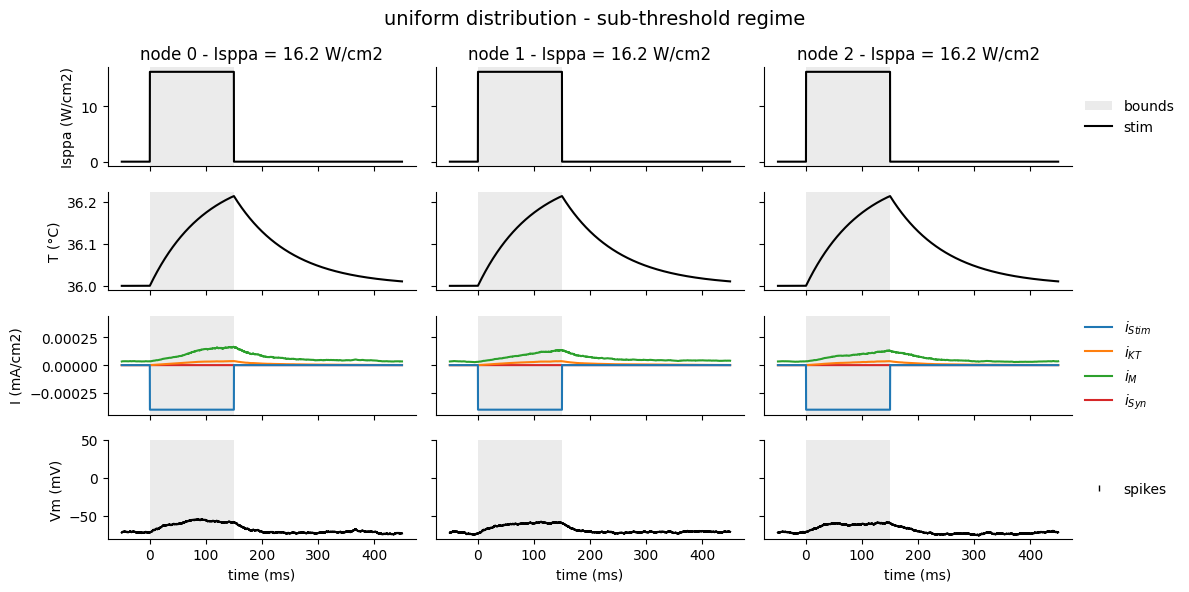

In [48]:
# Set preferred noise amplitude
model.noise_amp = 2e-3  # mA/cm2

# Find just sub-threshold Isppa values from preferred noise amplitude
nspikes_thr = 1
Ithrs = model.find_threshold(metric, value=nspikes_thr).loc[model.noise_amp]

# For each stimulus distribution - Isppa pair
for kind, Ithr in Ithrs.items():
    # Set stimulus
    model.set_stim(Ithr * model.get_stimdist_vector(kind))
    # Simulate model until sub-threshold regime is reached
    data = model.simulate()
    nit = 1
    while nit < 100 and model.compute_metric(data, 'nspikes').max() >= nspikes_thr:
        data = model.simulate()
        nit += 1
    if model.compute_metric(data, 'nspikes').max() >= nspikes_thr:
        logger.warning(f'Failed to reach sub-threshold regime for {kind} distribution after {nit} iterations')
    # Plot results
    fig = model.plot_results(
        data, 
        exclude=['conductances', 'iNa', 'iKd', 'iLeak', 'iNoise'], 
        clip_currents=True)
    fig.suptitle(f'{kind} distribution - sub-threshold regime', fontsize=14)
    # Save figure
    fig.savefig(f'{kind}_subthreshold.pdf')

## Log completion

In [7]:
logger.info(f'notebook completed in {timedelta(seconds=time.perf_counter() - t0)}')

 12/12/2023 18:01:36: notebook completed in 0:13:13.925222
